In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Plotting functions

In [2]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [3]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [4]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [5]:
def generate_problem_synthetic_2_AR(n_elements, mode = 'prophet', seed = 123):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time,2,1,1,0.1,0), 
                           f_1(Time,1,0.5,0.2,-0.1,0.01), 
                           f_1(Time,1,0.6,1,0.5,0.02), 
                           f_1(Time,1,0.7,0.5,0.5,-0.02) + 10], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog)
    
    y_with_lags = generate_ts_2(Exog)
    
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [6]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [7]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [8]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [9]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")
    
    model.fit(data_train_new)
    
    return model

In [10]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [11]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, seasonal = params['seasonal'],
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [12]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [13]:
def f_1(time,start,k,sigma,c,ct,seed = 123):
    """
    time: np.array (len_ts,)
    k: parameter of AR(1)
    sigma: variance of noise
    c: constant part of trend
    ct : koef of linear part of trend
    """
    len_ts = time.shape[0]
    np.random.seed(seed)
    f = np.empty(len_ts)
    f[0] = start
    w = np.random.normal(size = len_ts, scale = sigma)
    for i in range(1,len_ts):
        f[i] = k * f[i-1] + c +ct * i + w[i]    
    return f.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y.squeeze()

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 1 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] - 0.5  * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.25 * y[i-3]
    return y


def generate_ts_nonlinear(exog):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 1] * exog[:, 2] + exog[:, 2] / exog[:, 3]
    
    return y

def generate_ts_nonlinear_with_lags(exog):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 0] * exog[:, 2] + exog[:, 1] / exog[:, 2]
    
    for i in range(2, exog.shape[0]):
        
        y[i] = y[i] + 0.2 * y[i-1] + 0.2 * y[i-2] + 0.1 * y[i-1]
        
    return y

# Pyramid Approach

In [14]:
# Global_mode
global_mode = 'pyramid'

# Generate problem

In [15]:
n_samples = 300
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, mode = global_mode, seed = 123)

# Train-test-split

In [16]:
start_point = 0
middle_point = 100
end_point = 300

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# with exog

In [17]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'oob'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'ct'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 10
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [18]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [19]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

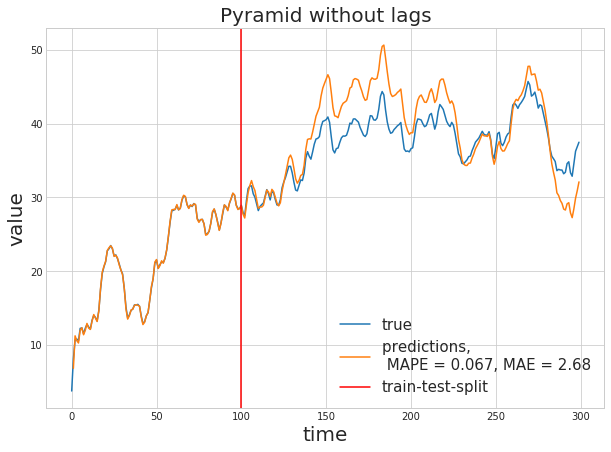

In [20]:
description = "Pyramid without lags"
plot_results(data_with_lags, Time, train_prediction, test_prediction, y_test_with_lags, global_mode, description)

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 3)   Log Likelihood                  72.633
Date:                Fri, 20 Jul 2018   AIC                           -123.266
Time:                        16:17:41   BIC                            -94.609
Sample:                             0   HQIC                          -111.668
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1213      0.360     -0.336      0.737      -0.828       0.585
drift          0.0044      0.006      0.730      0.465      -0.007       0.016
x1             1.8280      0.166     11.005      0.000       1.502       2.154
x2            -3.4512      0.324    -10.659      0.000      -4.086      -2.817
x3            -1.1977      0.410     -2.920      0.004      -2.002      -0.394
x4             1.4796      1.049      1.411      0.158      -0.576       3.535
ar.L1          0.9742      0.032     30.558      0.000       0.912       1.037
ma.L1          2.8102      0.099     28.348      0.000       2.616       3.004
ma.L2          2.6893      0.186     14.423      0.000       2.324       3.055
ma.L3          0.8733      0.088      9.938      0.000       0.701       1.046
sigma2         0.0101      0.002      4.595      0.000       0.006       0.014
===================================================================================
Ljung-Box (Q):                       77.69   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.00   Prob(JB):                         0.71
Heteroskedasticity (H):               0.35   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
c = model.params()[0]
ct = model.params()[1]
ex_params = model.params()[2:6]
phi_1 = model.params()[6]
theta = model.params()[7:10]
last_from_train = data_train_with_lags[-1]

In [91]:
model.params()

array([-0.12127892,  0.00444863,  1.8279714 , -3.45122926, -1.1977307 ,
        1.47960306,  0.97421736,  2.81017019,  2.68934316,  0.87328984,
        0.01012048])

$$
SARIMAX(1,0,3) \rightarrow ARMA(1,3)
$$
$\Rightarrow$
$$
y_t = c_0 + c_1t + x_1 Exog^1_t + x_2 Exog^2_t + x_3 Exog^3_t + x_4 Exog^4_t + \phi_1 y_{t-1} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \theta_3 \epsilon_{t-3} + \epsilon_t
$$
$\Rightarrow$


$$
y_t = 0.121 + 0.004 t + 1.827 *Exog^1_t - 3.451* Exog^2_t -1.197 *Exog^3_t + 1.479* Exog^4_t + \\+0.972 * y_{t-1} + 2.810* \epsilon_{t-1} + 2.689* \epsilon_{t-2} + 0.873* \epsilon_{t-3} + \epsilon_t
$$, where $\epsilon \sim \mathcal{N}(0, 0.010)$

In [31]:
def generate_path_from_formula(n_periods = 300):
    y = np.empty(n_periods)
    y[0] = c+ phi_1 * (last_from_train- ex_params @ exog[-1]) + ex_params @ exog[0]
    for i in range(1,300):
        y[i] = c + ct * i + phi_1 * (y[i-1] - ex_params @ exog[i-1]) + ex_params @ exog[i]
    return y

In [34]:
test_prediction_direct = generate_path_from_formula()[100:]

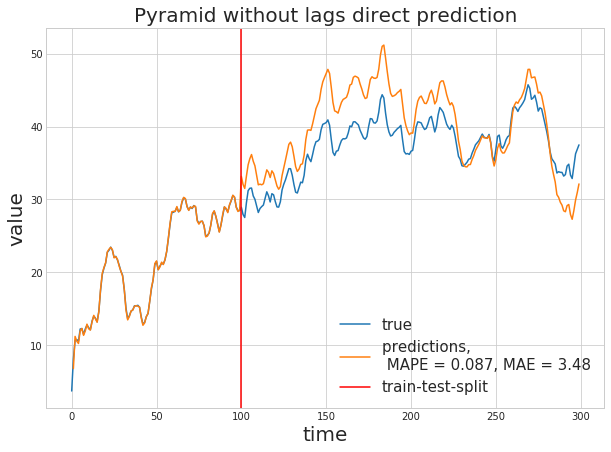

In [35]:
description = "Pyramid without lags direct prediction"
plot_results(data_with_lags, Time, train_prediction, test_prediction_direct, y_test_with_lags, global_mode, description)

In [36]:
direct_ts = exog @ ex_params.T 
residual = data_with_lags - direct_ts

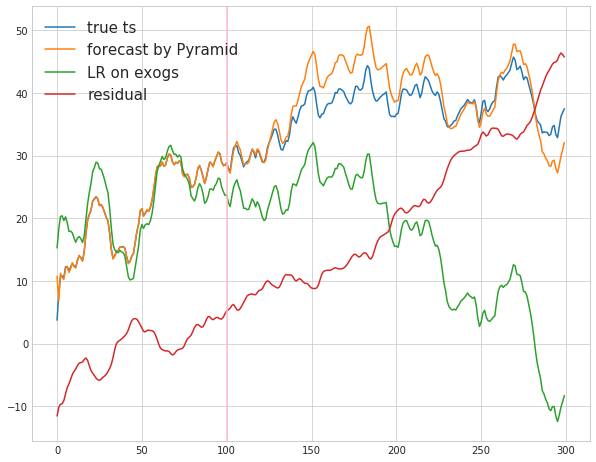

In [89]:
plt.figure(figsize=(10,8))
plt.plot(data_with_lags, label = "true ts")
plt.plot(np.concatenate([ train_prediction, test_prediction]), label = "forecast by Pyramid")
plt.plot(direct_ts, label = "LR on exogs")
plt.plot(residual,label = "residual")
plt.legend(loc=2, prop={'size': 15})
plt.axvline(x=100, label = "train-test-split", color = 'pink')
plt.show()

In [43]:
def generate_path_from_formula_without_exog(residual,n_periods = 300):
    y = np.empty(n_periods)
    y[0] = residual[0]
    for i in range(1,100):
        y[i] = c + ct * i + phi_1 * residual[i-1]
    for i in range(100,300):
        y[i] = c + ct * i + phi_1 * y[i-1]
    return y

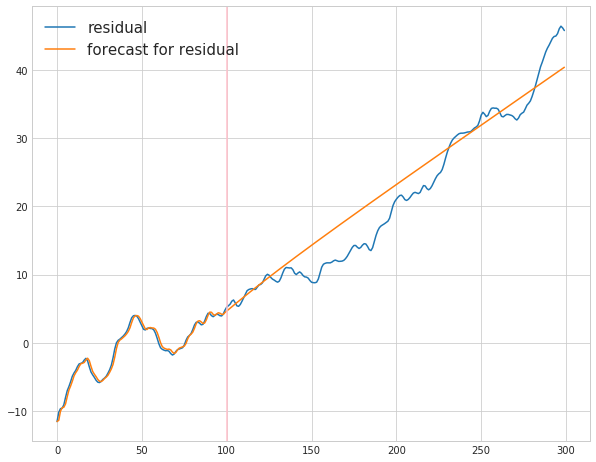

In [88]:
plt.figure(figsize=(10,8))
plt.plot(residual, label = "residual")
plt.plot(generate_path_from_formula_without_exog(residual), label = "forecast for residual")
plt.legend(loc=2, prop={'size': 15})
plt.axvline(x=100, label = "train-test-split", color = 'pink')
plt.show()